<a href="https://colab.research.google.com/github/openfoodfacts/off-product-environmental-impact/blob/master/analysis/colab/OFF%20impact%20estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting performance of the impact estimator

*Authors: Martin Bruse (zond@google.com), Shu Li (lishu@google.com)*

To enable reliable use of Gustave's impact estimator, we need to know not only how well it performs in general, but also be able to predict how well it performs on individual products from the production data set - i.e. we need to know if the performance on a given product is good enough to use the estimated impact instead of the category impact picked from the AgriBalyse dataset.

This Colab aims to help understanding this problem, as well as provide a practical heuristic for determining which products the estimator provides a precise enough estimate for.

In [1]:
#@title Import necessary packages
import requests
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from functools import reduce
from io import StringIO
from mpl_toolkits.mplot3d import Axes3D  
import scipy
!pip install tqdm
from tqdm.notebook import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load test data

We created test data by combining the AgriBalyse compound products put together by Gustave and his team (found at https://github.com/openfoodfacts/off-product-environmental-impact/blob/master/analysis/test_dataset_nutri_from_ciqual.json) with the results of running the estimator on them.

We provided flags to not ignore unknown ingredients (since there are a lot of them in production we prefer to treat them as uncharacterized ingredients), return the generated distributions in the results, and compute the impacts using `EF single score` and `Climate change`.

We did this using https://github.com/openfoodfacts/off-product-environmental-impact/blob/master/analysis/generate.py, calling it with the command line
```
[projects/off-product-environmental-impact{master}]$ docker-compose -f docker-compose.yml \
  -f docker-compose-generate-data.yml run --rm \
  off-product-environmental-impact python generate.py --input_file=test_dataset_nutri_from_ciqual.json \
  --combos_per_product=32 --output_file=generated.json \
  --parallellism=64
```
and storing it at https://github.com/openfoodfacts/off-product-environmental-impact/blob/master/analysis/colab/generated_test_data_with_randomly_provided_percentages_and_randomly_uncharacterized_ingredients.json.bz2.

In [2]:
!curl -C - -L -O https://github.com/openfoodfacts/off-product-environmental-impact/raw/master/analysis/colab/generated_test_data_with_randomly_provided_percentages_and_randomly_uncharacterized_ingredients.json.bz2
!bunzip2 generated_test_data_with_randomly_provided_percentages_and_randomly_uncharacterized_ingredients.json.bz2
raw_data = pd.io.json.read_json("generated_test_data_with_randomly_provided_percentages_and_randomly_uncharacterized_ingredients.json")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   273  100   273    0     0   1568      0 --:--:-- --:--:-- --:--:--  1568
100 37.6M  100 37.6M    0     0  44.4M      0 --:--:-- --:--:-- --:--:--  119M


# Decorate the test data

The below code will filter and decorate the generated test data to enable some simple analysis.

Since Eco-Score ~= log of impact (there's a greater difference between Eco-Score D and E than between A and B to make sure there are products across the entire spectrum - otherwise all veggies would be A and everything else E) we use the log of impact. Basically the "original" scale (scale of the Eco-Score) in this case is log  of the impact.

In [3]:
def score_decoration(raw_data):
  # Filter out all successful estimations.
  data = raw_data[~raw_data['estimation'].isnull()]
  # Filter out all successful estimations with EF single score.
  data = data[data.estimation.apply(lambda x: 'EF single score' in x['impact_distributions'])]
  # Decorate with product name.
  data['product_name'] = data.ground_truth.apply(lambda x: x['product_name'])
  # Decorate with log of the EF single score with the highest confidence score.
  data['log_max_confidence_ef_single_score'] = data.estimation.apply(lambda x: np.log(x['impact_distributions']['EF single score'][np.argmax(x['confidence_score_distribution'])]))
  # Decorate with log of the ground truth EF single score (from AgriBalyse).
  data['log_true_ef_single_score'] = data.ground_truth.apply(lambda x: np.log(x['impacts']['Score unique EF']))
  # Decorate with the error ratio of max confidence EF single score.
  data['error_ratio_log_ef_single_score'] = ((data['log_true_ef_single_score'] - data['log_max_confidence_ef_single_score']) / data['log_max_confidence_ef_single_score']).abs()
  # Decorate with log of geometric mean EF single score from Gustave's library - i.e. the "best guess" without actual guessed mixture.
  data['log_geom_mean_ef_single_score'] = data.estimation.apply(lambda x: np.log(x['impacts_geom_means']['EF single score']))
  return data

data = score_decoration(raw_data)
data

,estimation,ground_truth,error,product_name,log_max_confidence_ef_single_score,log_true_ef_single_score,error_ratio_log_ef_single_score,log_geom_mean_ef_single_score
0,"{'average_total_used_mass': 50.0, 'calculation...","{'categories_tags': ['en:sauces', 'en:grocerie...",NaN,"Aioli sauce (garlic and olive oil mayonnaise),...",-3.695514,-3.084146,0.165435,-3.673974
1,"{'average_total_used_mass': 49.99999999999999,...","{'categories_tags': ['en:sauces', 'en:grocerie...",NaN,"Aioli sauce (garlic and olive oil mayonnaise),...",-3.642737,-3.084146,0.153344,-3.640570
2,{'average_total_used_mass': 100.47573562266746...,"{'categories_tags': ['en:marzipan'], 'impacts'...",NaN,"Almond paste or marzipan, prepacked",-2.146012,-2.213860,0.031616,-2.146940
3,"{'average_total_used_mass': 50.00000000000001,...","{'categories_tags': ['en:sauces', 'en:grocerie...",NaN,"Aioli sauce (garlic and olive oil mayonnaise),...",-3.708796,-3.084146,0.168424,-3.697637
4,"{'average_total_used_mass': 50.00000000000002,...","{'categories_tags': ['en:sauces', 'en:grocerie...",NaN,"Aioli sauce (garlic and olive oil mayonnaise),...",-3.688200,-3.084146,0.163780,-3.672032
...,...,...,...,...,...,...,...,...
16789,"{'average_total_used_mass': 91.64935600613451,...","{'categories_tags': ['en:dairy-desserts', 'en:...",NaN,Yogurt cake,-4.608909,-3.726691,0.191416,-4.854109
16790,{'average_total_used_mass': 100.00000000000003...,"{'categories_tags': ['en:plant-based-foods', '...",NaN,"White rice, cooked, with chicken",-3.281548,-3.506186,0.068455,-3.531917
16791,{'average_total_used_mass': 100.00000000000004...,"{'categories_tags': ['en:beverages', 'en:wine-...",NaN,Wine-based aperitif,-24.902182,-4.658192,0.812940,-19.315000
16792,{'average_total_used_mass': 100.00000000000004...,"{'categories_tags': ['en:fermented-foods', 'en...",NaN,"Yogurt, fermented milk or dairy specialty, w c...",-5.206303,-3.902806,0.250369,-4.573619


# Max confidence impact vs geometric mean impact

To enable simple communications with producers and users, we want to be able to publish the mixture we used when estimating the impact.

This will allow producers to see that we used the wrong mixture (and inform us about the correct one), or allow us to inform the producers of which ingredients are responsible for the score they got.

From the Pearson correlation matrix (linear correlation between the numeric columns) we can see that the "geometric mean impact" from Gustave's library (the best guess, essentially) is very strongly correlated with the score of the mixture with highest confidence.

This means we can probably safely use the mixture with highest confidence and its impact as the canonical "estimated recipe and impact" instead of the geometric mean, allowing us to publish an estimated recipe.

We also see that both the geometric mean and the max confidence impacts are not that strongly correlated with the true impact. We obviously need to understand this more.

In [4]:
data.corr(method='pearson')

,log_max_confidence_ef_single_score,log_true_ef_single_score,error_ratio_log_ef_single_score,log_geom_mean_ef_single_score
log_max_confidence_ef_single_score,1.000000,0.549511,-0.314519,0.987298
log_true_ef_single_score,0.549511,1.000000,0.313252,0.572337
error_ratio_log_ef_single_score,-0.314519,0.313252,1.000000,-0.312203
log_geom_mean_ef_single_score,0.987298,0.572337,-0.312203,1.000000


To really see the correlation between geometric mean and max confidence scores, they can be pairwise plotted on one axis each.

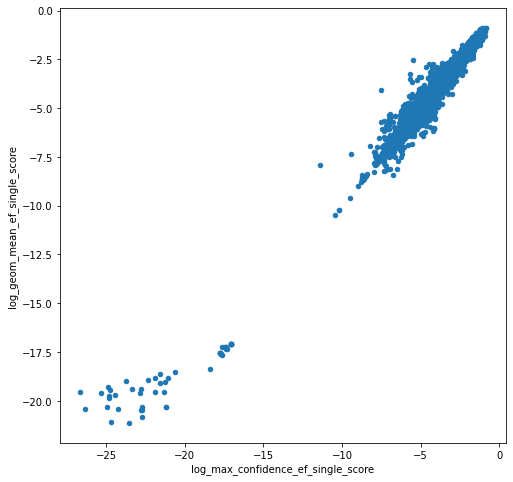

In [5]:
data.plot(kind='scatter', x='log_max_confidence_ef_single_score', y='log_geom_mean_ef_single_score', figsize=(8, 8))

# Max confidence impact vs ground truth impact

Since we decorated the dataset with error ratio of the impacts, it's simple to plot a histogram of the errors in our estimations.

Unfortunately there are some errors that are quite large, that we definitely don't want to apply in the user interface.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7efc04a50>]],
      dtype=object)

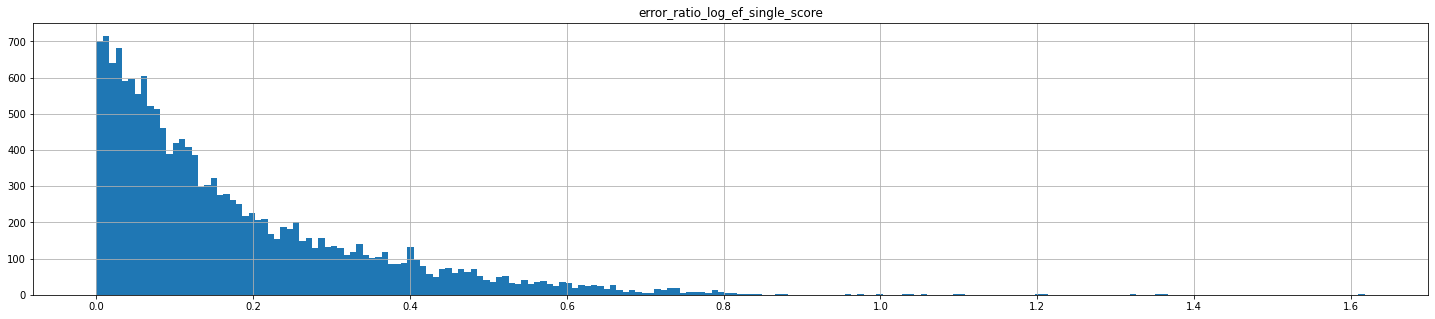

In [6]:
data.hist(column='error_ratio_log_ef_single_score', bins=200, figsize=(25,5))

Plotting max confidence score and true score pairwise on one axis shows exactly how bad the predictions are.

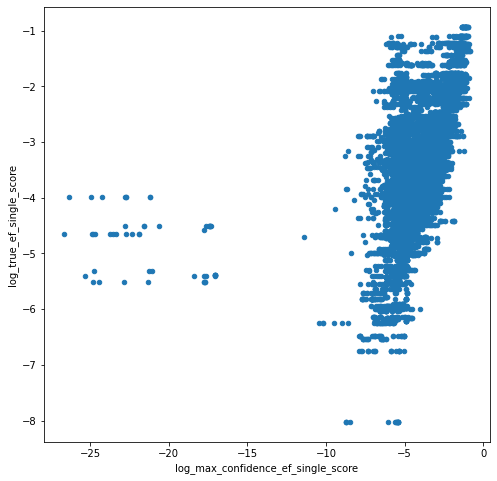

In [7]:
data.plot(x='log_max_confidence_ef_single_score', y='log_true_ef_single_score', kind='scatter', figsize=(8, 8))

# Standard deviation and uncharacterized ingredients

A reasonable assumption is that the amount of uncharacterized (lacking impact and/or nutritional data) ingredients, and the standard deviation within generated mixtures (since differences in mixture comes from uncertainty of the ingredient ratios) of the impacts from the generated mixtures, can influence the error of the predicted impact.

As the below correlation matrix shows, they do indeed have some correlation, especially ratio of "uncharacterized" ingredients.

In [8]:
def extra_decoration(data):
  # Decorate with amount of unrecognized ingredients.
  data['mass_ratio_uncharacterized'] = data.estimation.apply(lambda x: x['uncharacterized_ingredients_mass_proportion']['impact'])
  # Decorate with the standard deviation of log of all generated EF single scores.
  data['ef_single_score_log_std_dev'] = data.estimation.apply(lambda x: np.std(np.log(x['impact_distributions']['EF single score'])))

extra_decoration(data)
data.corr(method='pearson')

,log_max_confidence_ef_single_score,log_true_ef_single_score,error_ratio_log_ef_single_score,log_geom_mean_ef_single_score,mass_ratio_uncharacterized,ef_single_score_log_std_dev
log_max_confidence_ef_single_score,1.000000,0.549511,-0.314519,0.987298,-0.102241,-0.199287
log_true_ef_single_score,0.549511,1.000000,0.313252,0.572337,0.025291,-0.013185
error_ratio_log_ef_single_score,-0.314519,0.313252,1.000000,-0.312203,0.399114,0.177311
log_geom_mean_ef_single_score,0.987298,0.572337,-0.312203,1.000000,-0.096295,-0.193882
mass_ratio_uncharacterized,-0.102241,0.025291,0.399114,-0.096295,1.000000,0.141567
ef_single_score_log_std_dev,-0.199287,-0.013185,0.177311,-0.193882,0.141567,1.000000


# Impact of uncharacterized ingredients

Plotting the error ratio and uncharacterized mass ratio makes it clear that uncharacterized ingredients affect the error a lot.

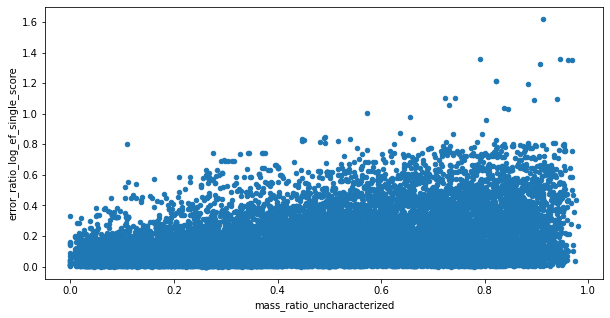

In [9]:
data.plot(kind='scatter', x='mass_ratio_uncharacterized', y='error_ratio_log_ef_single_score', figsize=(10,5))

It's obvious we need to explore exactly how unrecognized ingredients impact the computation, and see if there are ways to improve, e.g. substitute by product-level impact for the unknown ingredient.

# Filtering out products with uncharacterized ingredients

Filtering out products with a lot of uncharacterized ingredients shows a much better error distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7e3fff5d0>]],
      dtype=object)

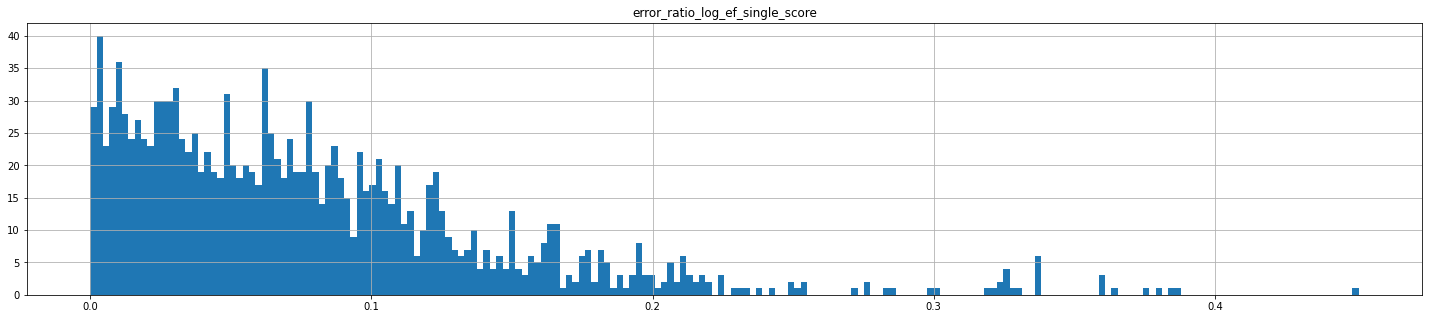

In [10]:
data[data.mass_ratio_uncharacterized < 0.1].hist(column='error_ratio_log_ef_single_score', bins=200, figsize=(25,5))

Plotting max confidence score and true score pairwise on one axis each confirms this.

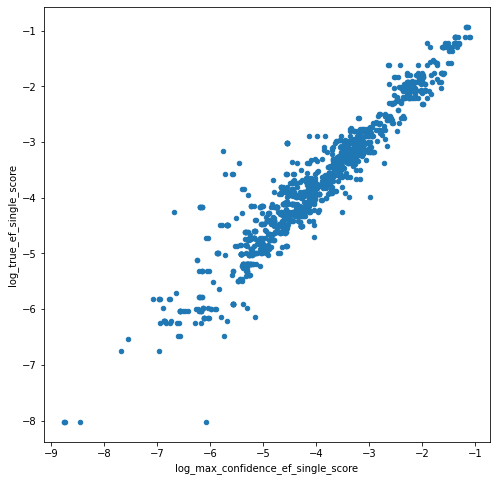

In [11]:
data[data.mass_ratio_uncharacterized < 0.1].plot(x='log_max_confidence_ef_single_score', y='log_true_ef_single_score', kind='scatter', figsize=(8, 8))

As an added bonus, the max confidence vs geometric mean errors also correlate much better now:

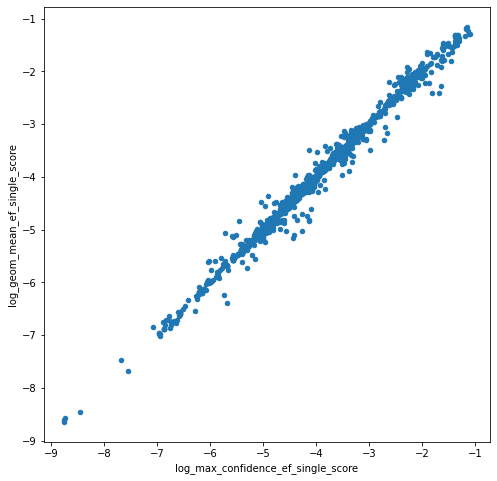

In [12]:
data[data.mass_ratio_uncharacterized < 0.1].plot(kind='scatter', x='log_max_confidence_ef_single_score', y='log_geom_mean_ef_single_score', figsize=(8, 8))

Finally, the correlation matrix also shows an increased correlation between standard deviation of generated mixtures and error ratio after filtering out the mixtures with lots of uncharacterized ingredients.

Even better, we clearly see the now much stronger correlation between the max confidence and geometric mean impacts and the true impacts!

In [13]:
data[data.mass_ratio_uncharacterized < 0.1].corr(method='pearson')

,log_max_confidence_ef_single_score,log_true_ef_single_score,error_ratio_log_ef_single_score,log_geom_mean_ef_single_score,mass_ratio_uncharacterized,ef_single_score_log_std_dev
log_max_confidence_ef_single_score,1.000000,0.955378,0.006218,0.995271,0.001915,0.051565
log_true_ef_single_score,0.955378,1.000000,0.230159,0.956837,0.040426,0.093076
error_ratio_log_ef_single_score,0.006218,0.230159,1.000000,0.013863,0.092154,0.306843
log_geom_mean_ef_single_score,0.995271,0.956837,0.013863,1.000000,-0.002130,0.035310
mass_ratio_uncharacterized,0.001915,0.040426,0.092154,-0.002130,1.000000,0.021713
ef_single_score_log_std_dev,0.051565,0.093076,0.306843,0.035310,0.021713,1.000000


# Plotting impact stddev and error

Plotting the stddev of the generated impacts against the impact error shows how little this correlation actually means - but it seems combining the uncharacterized mass ratio and the error standard deviation might let us predict the max error fairly well.

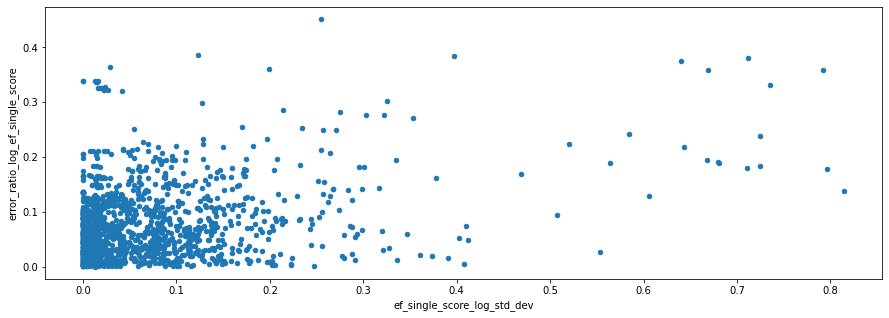

In [14]:
data[data.mass_ratio_uncharacterized < 0.1].plot(kind='scatter', x='ef_single_score_log_std_dev', y='error_ratio_log_ef_single_score', figsize=(15,5))

# Cross validation

Splitting the data into 10 parts, and for each part compute the average error at 95th percentile using given thresholds for that part (the test set) and the other parts (the train set) gives us some information about how valid assumptions about the resulting quantile errors are:

In [15]:
# Returns the max uncharacterized mass ratio threshold required to reduce the error to max_error at the given quantile.
def find_threshold_for_error_quantile(train_data, max_error, quantile):
  # Sort data by score stddev.
  train_data = train_data.sort_values(by=['mass_ratio_uncharacterized']).reset_index()
  # We look in the entire sorted frame.
  min_step = 0
  max_step = train_data.shape[0]
  while True:
    # Look at the midpoint.
    threshold_point = min_step + ((max_step - min_step) // 2)
    at_threshold = train_data.iloc[:threshold_point]['error_ratio_log_ef_single_score'].quantile(q=quantile)
    if at_threshold > max_error:
      # Midpoint error was too large.
      if np.abs(min_step - threshold_point) < 2:
        # We can't move closer to min without hitting it, set to min and break.
        threshold_point = min_step
        break
      # Move upper bound to here.
      max_step = threshold_point
    else:
      # Midpoint error wasn't large enough.
      if np.abs(max_step - threshold_point) < 2:
        # We can't move closer to max without hitting it, leave threshold and break.
        break
      # Move lower bound to here.
      min_step = threshold_point

  # Return the stddev at the threshold point.  
  return(train_data.mass_ratio_uncharacterized[threshold_point])

In [16]:
def cross_correlate(data, max_error, stddev_threshold=1.0, quantile=0.95):
  data = data[data.ef_single_score_log_std_dev < stddev_threshold]
  splits = 10
  num_per_split = data.shape[0] // splits
  partitions = [data.iloc[split * num_per_split:(split+1) * num_per_split] for split in range(splits)]
  test_data_results = []
  for validation_idx in range(splits):
    train_data_ary = []
    for idx in range(splits):
      if idx != validation_idx:
        train_data_ary.append(partitions[idx])
    train_data = pd.concat(train_data_ary)
    uncharacterized_mass_threshold = find_threshold_for_error_quantile(train_data, max_error, quantile)

    test_data = partitions[validation_idx]
    test_data_results.append(test_data[test_data.mass_ratio_uncharacterized < uncharacterized_mass_threshold]['error_ratio_log_ef_single_score'].quantile(q=quantile))


  print(('Average error at quantile {} for test set using thresholds {} (max uncharacterized mass ratio) \n' +
         'and {} (max error standard deviation) optimized for max error {} using train set').format(quantile, uncharacterized_mass_threshold, stddev_threshold, max_error))
  print('Test average: {}'.format(np.average(test_data_results)))
  print()

cross_correlate(data, 0.4)
cross_correlate(data, 0.3)
cross_correlate(data, 0.2)
cross_correlate(data, 0.15, stddev_threshold=0.05)

Average error at quantile 0.95 for test set using thresholds 0.6135277190107421 (max uncharacterized mass ratio) 
and 1.0 (max error standard deviation) optimized for max error 0.4 using train set
Test average: 0.3938221390954586

Average error at quantile 0.95 for test set using thresholds 0.36964604108105803 (max uncharacterized mass ratio) 
and 1.0 (max error standard deviation) optimized for max error 0.3 using train set
Test average: 0.29518824193094645

Average error at quantile 0.95 for test set using thresholds 0.089120982255236 (max uncharacterized mass ratio) 
and 1.0 (max error standard deviation) optimized for max error 0.2 using train set
Test average: 0.19705179206602846

Average error at quantile 0.95 for test set using thresholds 0.050684037144873004 (max uncharacterized mass ratio) 
and 0.05 (max error standard deviation) optimized for max error 0.15 using train set
Test average: 0.1417530872890392



# Bootstrapping

Computing the error at 95th percentile using given thresholds for a new set generated by sampling from the data using replacement, and then plotting the histogram of those errors, gives us some information about how the same errors would be distributed if we instead generated them from a larger set with a similar distribution as our data.

We may assume that the set of real world products is not distributed like our test data here, unfortunately - but if it _was_, we can be 95% confident about what that error at the 95th percentile would be for some sets of thresholds.

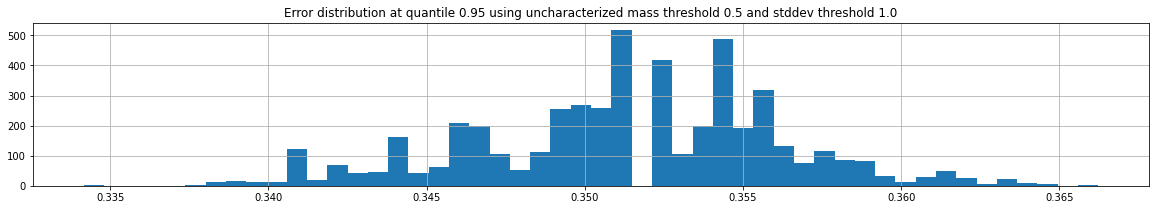

With 95% confidence the error at quantile 0.95 will be between 0.34103336231509185 and 0.3609802107688468


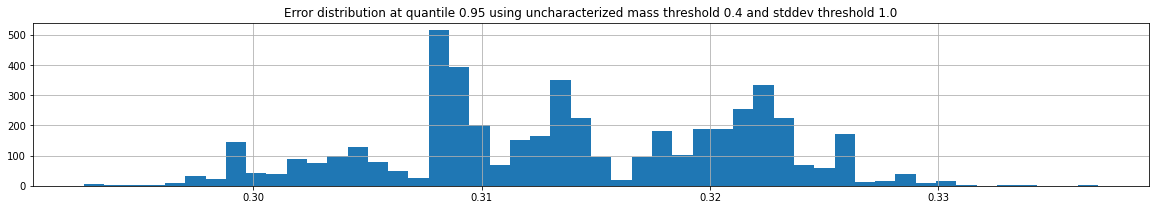

With 95% confidence the error at quantile 0.95 will be between 0.2992321335326409 and 0.325932411373778


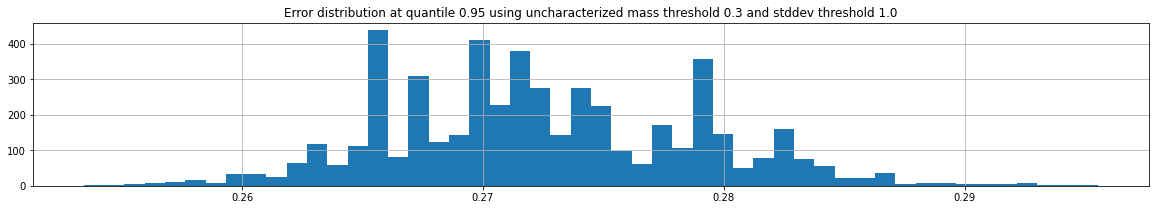

With 95% confidence the error at quantile 0.95 will be between 0.2617158929548102 and 0.2847821110975671


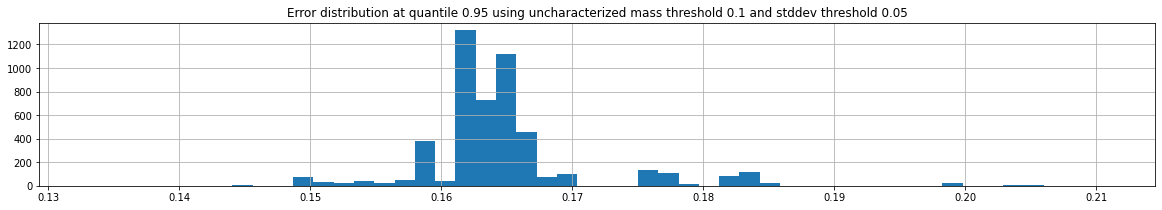

With 95% confidence the error at quantile 0.95 will be between 0.15332598294813496 and 0.18292952941312865


In [17]:
def bootstrap(data, uncharacterized_mass_threshold, stddev_threshold, quantile=0.95, n=5000, frac=1):
  filtered = data[(data.ef_single_score_log_std_dev < stddev_threshold) & (data.mass_ratio_uncharacterized < uncharacterized_mass_threshold)]['error_ratio_log_ef_single_score']
  results = []
  for idx in range(n):
    results.append(filtered.sample(frac=frac, replace=True).quantile(q=quantile))
  colname = 'Error distribution at quantile {} using uncharacterized mass threshold {} and stddev threshold {}'.format(quantile, uncharacterized_mass_threshold, stddev_threshold)
  result_frame = pd.DataFrame(results, columns=[colname])
  result_frame.hist(column=colname, bins=50, figsize=(20,3))
  plt.show()
  print(f'With 95% confidence the error at quantile {quantile} will be between {result_frame[colname].quantile(q=0.025)} and {result_frame[colname].quantile(q=0.975)}')

bootstrap(data, 0.5, 1.0)
bootstrap(data, 0.4, 1.0)
bootstrap(data, 0.3, 1.0)
bootstrap(data, 0.1, 0.05)

# Production data

Let's now load products decorated with estimations from the production data.


In [18]:
!curl -C - -L -O https://github.com/openfoodfacts/off-product-environmental-impact/raw/master/analysis/colab/estimated_productopener_products.json.bz2
!bunzip2 estimated_productopener_products.json.bz2
raw_prod_data = pd.io.json.read_json("estimated_productopener_products.json")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0   1272      0 --:--:-- --:--:-- --:--:--  1265
100 16.7M  100 16.7M    0     0  23.0M      0 --:--:-- --:--:-- --:--:-- 23.0M


And decorate the production data like we decorated the test data, and filter out things without either AgriBalyse or estimated impacts.

In [43]:
def prod_data_decoration(raw_data):
  # Filter out all successful estimations.
  data = raw_data[~raw_data['ecoscore_extended_data'].isnull()]
  # Filter out all successful estimations.
  data = data[data.ecoscore_extended_data.apply(lambda x: 'impact' in x)]
  # Filter out all successful estimations with EF single score.
  data = data[data.ecoscore_extended_data.apply(lambda x: 'EF_single_score' in x['impact']['likeliest_impacts'] and x['impact']['likeliest_impacts']['EF_single_score'] > 0)]
  # Filter out all products without AgriBalyse data with agriculture value.
  data = data[data.ecoscore_data.apply(lambda x: 'agribalyse' in x and 'ef_agriculture' in x['agribalyse'] and float(x['agribalyse']['ef_agriculture']) > 0)]
  # Decorate with log of the EF single score with the highest confidence score.
  data['log_max_confidence_ef_single_score'] = data.ecoscore_extended_data.apply(lambda x: np.log(x['impact']['likeliest_impacts']['EF_single_score']))
  # Decorate with AgriBalyse proxy score.
  data['log_agribalyse_ef_single_score'] = data.ecoscore_data.apply(lambda x: np.log(float(x['agribalyse']['ef_agriculture'])))
  # Decorate with delta ratio between log of AgriBalyse EF single score and max confidence EF single score.
  data['delta_ratio_log_ef_single_score'] = ((data['log_agribalyse_ef_single_score'] - data['log_max_confidence_ef_single_score']) / data['log_max_confidence_ef_single_score']).abs()
  # Decorate with unrecognized ingredients.
  data['mass_ratio_uncharacterized'] = data.ecoscore_extended_data.apply(lambda x: x['impact']['mass_ratio_uncharacterized'])
  # Decorate with std dev of the generated ef single scores.
  data['ef_single_score_log_std_dev'] = data.ecoscore_extended_data.apply(lambda x: x['impact']['ef_single_score_log_stddev'])
  return data

prod_data = prod_data_decoration(raw_prod_data)
prod_data

,_id,_keywords,added_countries_tags,additives_n,additives_old_n,additives_old_tags,additives_original_tags,additives_tags,allergens,allergens_from_ingredients,allergens_from_user,allergens_hierarchy,allergens_tags,amino_acids_tags,brands,brands_tags,carbon_footprint_from_known_ingredients_debug,carbon_footprint_percent_of_known_ingredients,categories,categories_hierarchy,categories_lc,categories_properties,categories_properties_tags,categories_tags,category_properties,checkers_tags,ciqual_food_name_tags,cities_tags,code,codes_tags,complete,completeness,correctors_tags,countries,countries_hierarchy,countries_lc,countries_tags,created_t,creator,data_quality_bugs_tags,...,ingredients_text_fr_ocr_1586355769_result,ingredients_text_de_ocr_1545761829,ingredients_text_de_ocr_1545761829_result,ingredients_text_de_ocr_1545829935,ingredients_text_de_ocr_1545829935_result,ingredients_text_de_ocr_1545829981,ingredients_text_de_ocr_1545829981_result,ingredients_text_en_ocr_1615885378,ingredients_text_en_ocr_1615885378_result,ingredients_text_fr_ocr_1571450392,ingredients_text_fr_ocr_1571450392_result,ingredients_text_es_ocr_1588083224,ingredients_text_es_ocr_1588083224_result,ingredients_text_fr_ocr_1550241785,ingredients_text_fr_ocr_1550241785_result,ingredients_text_fr_ocr_1550256794,ingredients_text_fr_ocr_1550256794_result,ingredients_text_fr_ocr_1637071075,ingredients_text_fr_ocr_1637071075_result,ingredients_text_es_ocr_1575061321,ingredients_text_es_ocr_1575061321_result,ingredients_text_it_ocr_1636267341,ingredients_text_it_ocr_1636267341_result,ingredients_text_fr_ocr_1550247283,ingredients_text_fr_ocr_1550247283_result,ingredients_text_es_ocr_1559574567,ingredients_text_es_ocr_1559574567_result,ingredients_text_es_ocr_1563707284,ingredients_text_es_ocr_1563707284_result,ingredients_text_en_ocr_1637066878,ingredients_text_en_ocr_1637066878_result,ingredients_text_es_ocr_1637066878,ingredients_text_es_ocr_1637066878_result,ingredients_text_fr_ocr_1583580329,ingredients_text_fr_ocr_1583580329_result,log_max_confidence_ef_single_score,log_agribalyse_ef_single_score,delta_ratio_log_ef_single_score,mass_ratio_uncharacterized,ef_single_score_log_std_dev
2,3.095757e+12,"[vert, volaille, cuite, tranche, poulet, nutri...",[],2.0,2.0,"[en:e301, en:e150a]","[en:e301, en:e150a]","[en:e150a, en:e301]",en:celery,"en:celery, céleri",(fr) en:celery,[en:celery],[en:celery],[],Fleury Michon,[fleury-michon],en:chicken-fillet 95% x 4.9 = 465.5 g -,95.0,"Viandes, Charcuteries, Volailles, Poulets, Cha...","[en:meats, en:prepared-meats, en:poultries, en...",fr,"{'agribalyse_food_code:en': '28963', 'ciqual_f...","[all-products, categories-known, agribalyse-fo...","[en:meats, en:prepared-meats, en:poultries, en...",{'ciqual_food_name:en': 'Cured meat and sausag...,[sebleouf],[cured-meat-and-sausages-average],[chantonnay-vendee-france],3.095757e+12,"[code-13, 3095757080xxx, 309575708xxxx, 309575...",0,0.8875,"[fleury-michon, yuka.WWY5Yk9yc0RwUElZeDlvaTlDN...",France,[en:france],fr,[en:france],1484768776,openfoodfacts-contributors,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.728474,-0.374987,0.862565,0.010979,0.024858
3,3.095757e+12,"[fleury, grille, de, charcuterie, epice, et, m...",[],2.0,2.0,"[en:e160c, en:e250]","[en:e160c, en:e250]","[en:e160c, en:e250]",en:celery,,(fr) en:celery,[en:celery],[en:celery],[],Fleury Michon,[fleury-michon],en:tomato-concentrate 0.3% x 0.5 = 0.15 g -,0.3,"Viandes, Charcuteries, Volailles, Poulets, Cha...","[en:meats, en:prepared-meats, en:poultries, en...",fr,"{'agribalyse_food_code:en': '28963', 'agribaly...","[all-products, categories-known, agribalyse-fo...","[en:meats, en:prepared-meats, en:poultries, en...",{},[],[unknown],"[meilleraie-tillay-vendee-france, chantonnay-v...",3.095757e+12,"[code-13, 3095757130xxx, 309575713xxxx, 309575...",0,1.0000,"[tacite, fleury-michon, yuka.WEtjT0w2SXp0OUlZa...",France,[en:france]

A respectable ratio of this data has less than 50% mass ratio uncharacterized ingredients, and a standard deviation of the ratio of the error of the log of the impact less than 1.0.

In [54]:
prod_data[(prod_data.mass_ratio_uncharacterized < 0.3) & (prod_data.ef_single_score_log_std_dev < 1.0)].shape[0] / raw_prod_data.shape[0]

0.41187570763618064

# Quality of AgriBalyse data

A histogram of the percentual difference between the AgriBalyse score and the most likely score from the estimator, shows that almost all AgriBalyse scores are very different from the estimated scores.

Considering the fact that our test data assumes a 95% confidence that 95% of these scores (less than 30% mass ratio uncharacterized ingredients, and error standard deviation less than 0.1) are less than ~27% off, all AgriBalyse proxy impacts in this histogram > 0.27 should be replaced with estimated values.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb7b49eeed0>]],
      dtype=object)

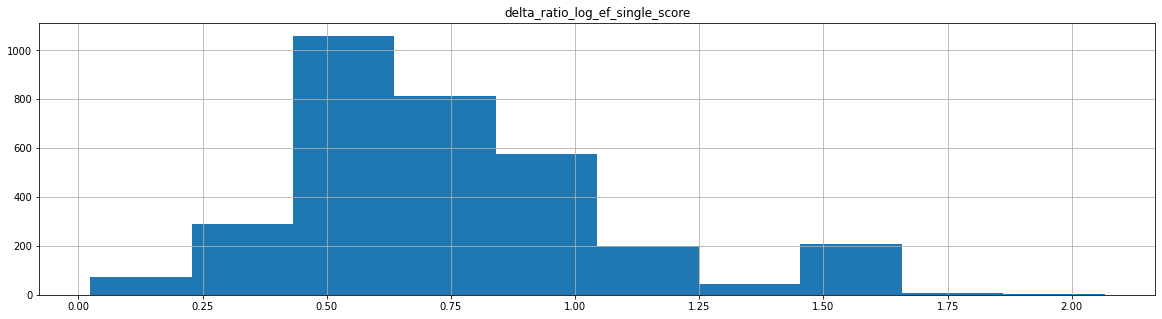

In [55]:
prod_data[(prod_data.mass_ratio_uncharacterized < 0.3) & (prod_data.ef_single_score_log_std_dev < 1.0)].hist(column='delta_ratio_log_ef_single_score', bins=10, figsize=(20,5))

# Individual product level decisions

If we create a function `error(quantile, confidence, standard_deviation, mass_ratio_uncharacterized_ingredients)` that returns the max error ratio at `quantile` with `confidence` for a given combination of `standard_deviation` and `mass_ratio_uncharacterized ingredients`, we'd be able to predict - for each product - the likely error of the estimation.

That will let us decide on a per-product level whether to use the AgriBalyse impact, or (if the difference between AgriBalyse impact and estimated impact are greater than the expected error) the estimated impact.

In [48]:
# Returns the maximum error ratio between log of AgriBalyse true impact and log of most likely
# impact at given quantile with given confidence when limiting standard deviation and mass ratio of
# uncharacterized ingredients.
def error(quantile, confidence, standard_deviation, mass_ratio_uncharacterized_ingredients):
  filtered = data[
                  (data.ef_single_score_log_std_dev < standard_deviation) &
                  (data.mass_ratio_uncharacterized < mass_ratio_uncharacterized_ingredients)]['error_ratio_log_ef_single_score']
  if filtered.shape[0] == 0:
    return np.nan
  results = []
  for idx in range(400):
    results.append(filtered.sample(frac=1.0, replace=True).quantile(q=quantile))
  colname = 'x'
  result_frame = pd.DataFrame(results, columns=[colname])
  res = result_frame[colname].quantile(q=confidence)
  return res

Plotting this function as a surface shows us the error that we believe 95% of all products with matching impact standard deviation and mass ratio of uncharaterized ingredients will be below, with 95% confidence.

In [49]:
stddev_axis = np.linspace(0.0, 1.0, 20)
ratio_axis = np.linspace(0.0, 1.0, 20) 
ratios, stddevs = np.meshgrid(ratio_axis, stddev_axis)
points = np.transpose(np.array([np.ravel(ratios), np.ravel(stddevs)]))
errors_list = []
print("Generating points")
for i in tqdm(range(len(points))):
  errors_list.append(error(0.95, 0.95, points[i][1], points[i][0]))

Generating points


  0%|          | 0/400 [00:00<?, ?it/s]

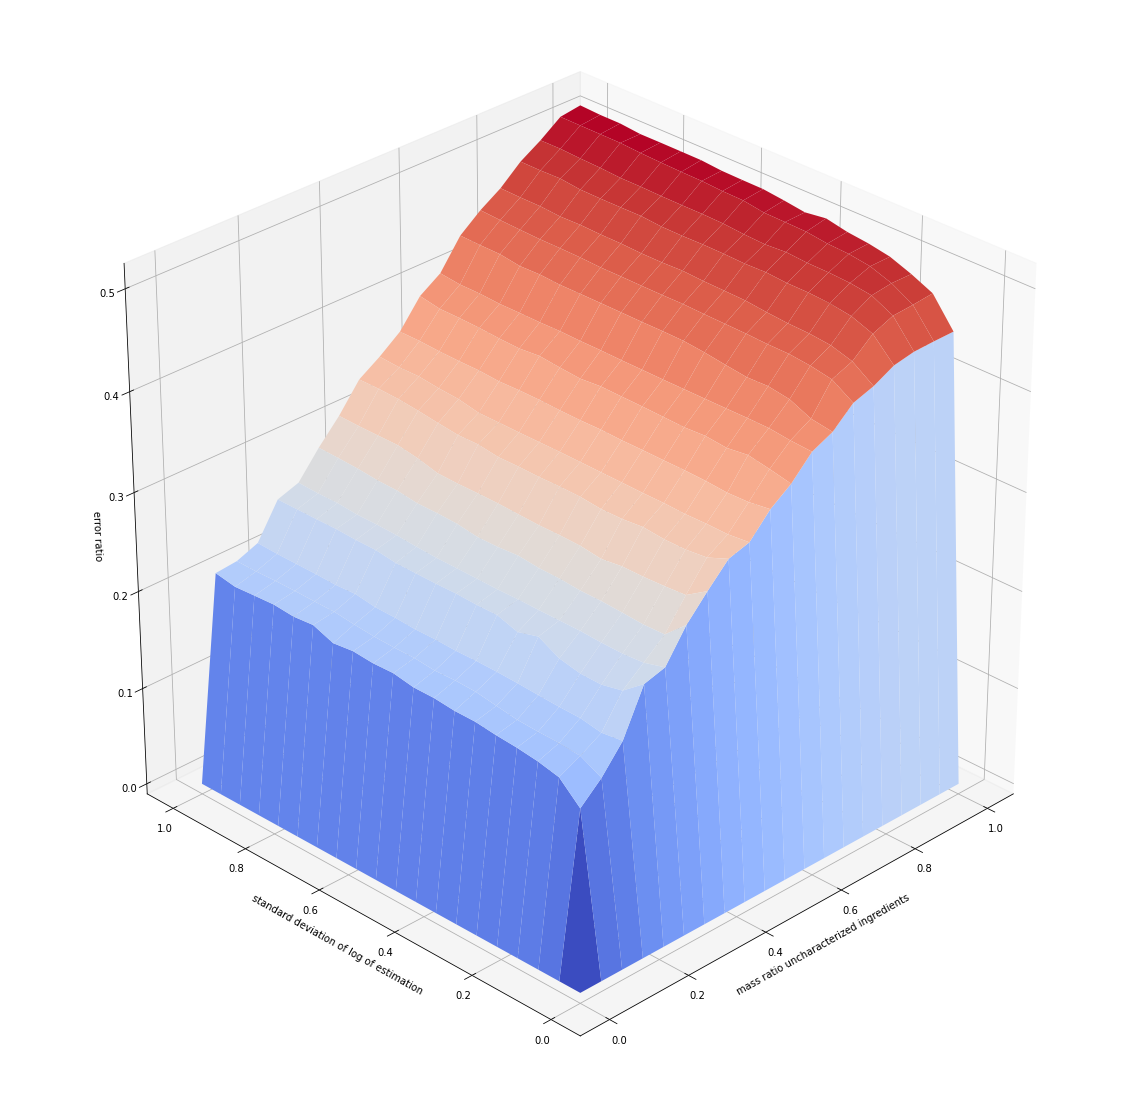

In [50]:
error_axis = np.array(errors_list)
errors = error_axis.reshape(ratios.shape)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(ratios, stddevs, np.nan_to_num(errors), cmap=cm.coolwarm)

ax.set_xlabel('mass ratio uncharacterized ingredients')
ax.set_ylabel('standard deviation of log of estimation')
ax.set_zlabel('error ratio')
ax.view_init(30, 225)

## Approximating the error surface

Fitting a second degree function to the error surface provides a quick way to estimate whether the ratio between AgriBalyse proxy impact and estimated impact is above or below the 95th percentile error, and should inform us about whether to use the estimated value or the AgriBalyse value.

In [51]:
unraveled_ratios = np.ravel(ratios)
unraveled_stddevs = np.ravel(stddevs)
unraveled_errors = np.ravel(errors)

def second_degree_fit(mass_ratio_uncharacterized, impact_standard_deviation, params):
  return (params[0] +
          params[1] * mass_ratio_uncharacterized +
          params[2] * impact_standard_deviation + 
          params[3] * mass_ratio_uncharacterized * impact_standard_deviation +
          params[4] * mass_ratio_uncharacterized * mass_ratio_uncharacterized +
          params[5] * impact_standard_deviation * impact_standard_deviation +
          params[6] * mass_ratio_uncharacterized * mass_ratio_uncharacterized * mass_ratio_uncharacterized +
          params[7] * mass_ratio_uncharacterized * mass_ratio_uncharacterized * impact_standard_deviation +
          params[8] * mass_ratio_uncharacterized * impact_standard_deviation * impact_standard_deviation +
          params[9] * impact_standard_deviation * impact_standard_deviation * impact_standard_deviation)

def losses(params):
  res = []
  for idx in range(len(unraveled_ratios)):
    if np.isnan(unraveled_errors[idx]) or np.isnan(unraveled_stddevs[idx]) or np.isnan(unraveled_errors[idx]):
      continue
    res.append(unraveled_errors[idx] - second_degree_fit(unraveled_ratios[idx], unraveled_stddevs[idx], params))
  return res

least_squares_fit = scipy.optimize.least_squares(losses, [1,1,1,1,1,1,1,1,1,1]).x
least_squares_fit

array([ 0.16575361,  0.22372483,  0.0436082 , -0.02109288,  0.45154202,
       -0.0649544 , -0.37523209,  0.12371023, -0.09035574,  0.06028717])

Generating points


  0%|          | 0/400 [00:00<?, ?it/s]

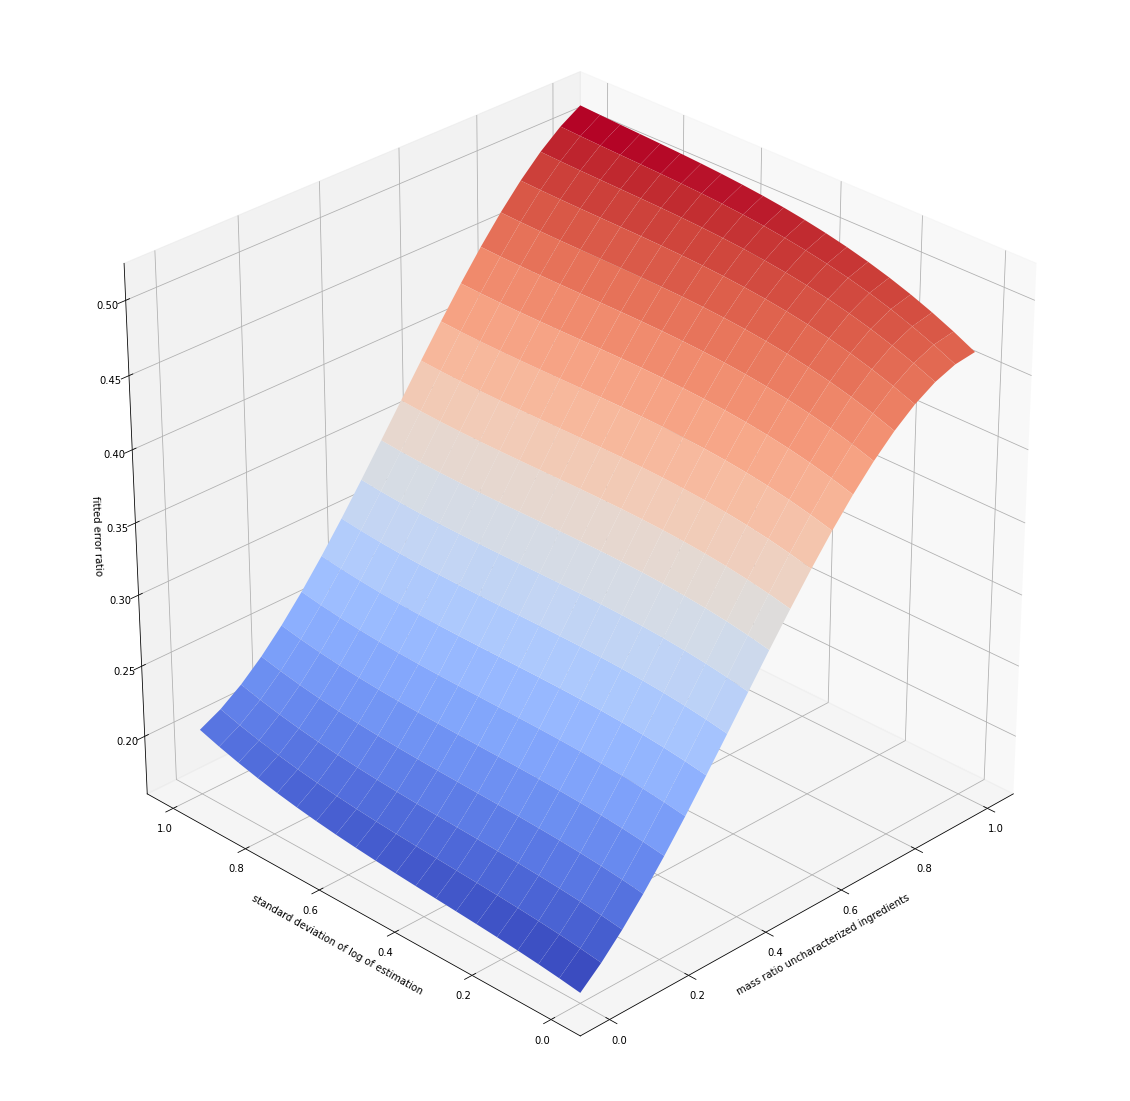

In [52]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
errors_list2 = []
print("Generating points")
for i in tqdm(range(len(points))):
  errors_list2.append(second_degree_fit(points[i][0], points[i][1], least_squares_fit))
error_axis2 = np.array(errors_list2)
errors2 = error_axis2.reshape(ratios.shape)

ax.plot_surface(ratios, stddevs, np.nan_to_num(errors2), cmap=cm.coolwarm)

ax.set_xlabel('mass ratio uncharacterized ingredients')
ax.set_ylabel('standard deviation of log of estimation')
ax.set_zlabel('fitted error ratio')
ax.view_init(30, 225)

# Computing coverage of improved Eco-Scores

If we decorate the production data with the predicted error ratio, we can then filter out all products where the difference between the AgriBalyse proxy score is greater than the predicted error for that particular product.

In [53]:
prod_data['predicted_error_ratio'] = prod_data.apply(lambda x: second_degree_fit(x.mass_ratio_uncharacterized, x.ef_single_score_log_std_dev, least_squares_fit), axis=1)
print(f'{prod_data[prod_data.predicted_error_ratio < prod_data.delta_ratio_log_ef_single_score].shape[0]} out of {raw_prod_data.shape[0]} products can be improved by using the estimated impact.')
print(f'=> {prod_data[prod_data.predicted_error_ratio < prod_data.delta_ratio_log_ef_single_score].shape[0] / raw_prod_data.shape[0]}')


3826 out of 7949 products can be improved by using the estimated impact.
=> 0.48131840483079635
